This work is sampled from: https://radimrehurek.com/data_science_python/

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
import pandas
import sklearn
# import cPickle -- only needed for saving production model
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.learning_curve import learning_curve

"""
If TextBlob doesn't import in a command line run:
pip install -U textblob
python -m textblob.download_corpora
"""

"\nIf TextBlob doesn't import in a command line run:\npip install -U textblob\npython -m textblob.download_corpora\n"

In [3]:
"""
Load, check data quantity, and look at a subset.

This file contains **a collection of more than 5 thousand SMS phone messages**
(see the `readme` file for more info).
"""
messages = [line.rstrip() for line in open('data/smsspamcollection/SMSSpamCollection')]
print('Number of messages loaded: ' + str(len(messages)))

# Print a sample of messages
for message_no, message in enumerate(messages[:10]):
    print(message_no, message)

Number of messages loaded: 5574
0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
1 ham	Ok lar... Joking wif u oni...
2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3 ham	U dun say so early hor... U c already then say...
4 ham	Nah I don't think he goes to usf, he lives around here though
5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv
6 ham	Even my brother is not like to speak with me. They treat me like aids patent.
7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
8 spam	WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701

We see that this is a [TSV](http://en.wikipedia.org/wiki/Tab-separated_values) ("tab separated values") file, where the first column is a label saying whether the given message is a normal message ("ham") or "spam". The second column is the message itself.

This corpus will be our labeled training set. Using these ham/spam examples, we'll **train a machine learning model to learn to discriminate between ham/spam automatically**. Then, with a trained model, we'll be able to **classify arbitrary unlabeled messages** as ham or spam.

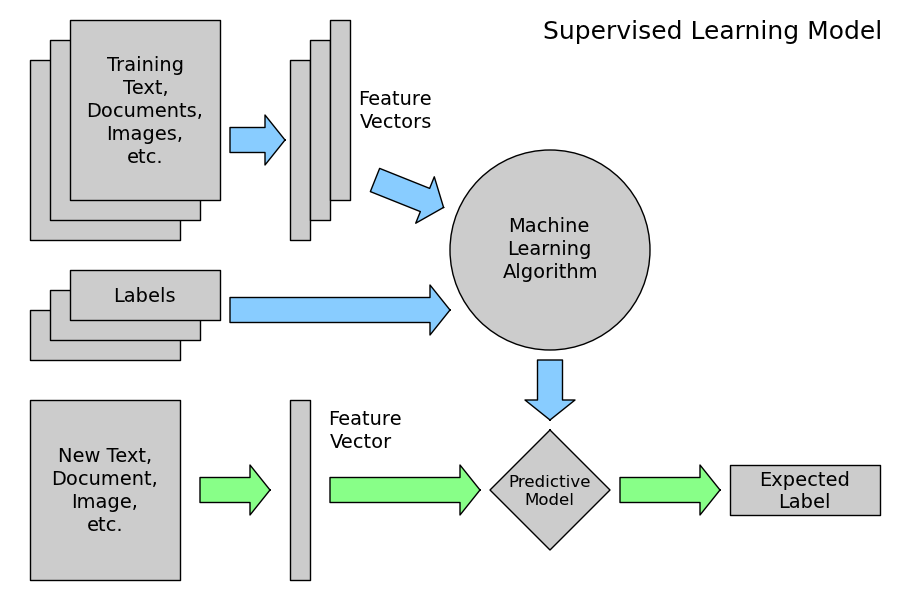

In [4]:
# Let's get this file into a structured format
messages = pandas.read_csv('data/smsspamcollection/SMSSpamCollection', sep='\t', quoting=csv.QUOTE_NONE,
                           names=["label", "message"])
messages.head(n=10)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [5]:
# Let's take a look at the distribution of Spam and Ham
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4827   4518                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a12924cf8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1096012b0>], dtype=object)

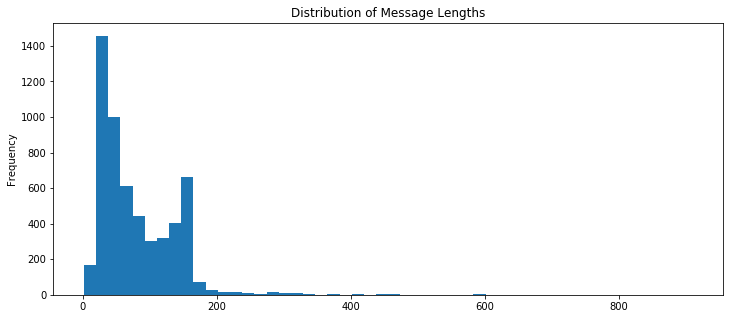

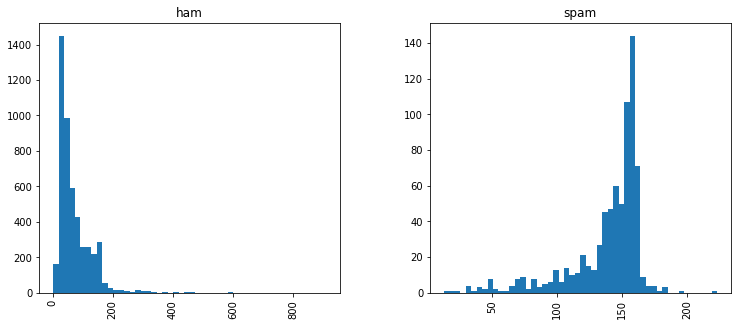

In [6]:
# About 13% of the corpus is spam.

# Let's take a look the text message length
messages['length'] = messages['message'].map(lambda text: len(text))
messages.length.plot(figsize=(12,5), bins=50, kind='hist', label='Number of Characters',
                     title='Distribution of Message Lengths')
messages.length.describe()
messages.hist(figsize=(12,5), column='length', by='label', bins=50)

Love how you can see the bi-modal aggregate distribution is created by the two different distributions of Ham and Spam

## Step 2: Data preprocessing

In this section we'll massage the raw messages (sequence of characters) into vectors (sequences of numbers).

The mapping is not 1-to-1; we'll use the [bag-of-words](http://en.wikipedia.org/wiki/Bag-of-words_model) approach, where each unique word in a text will be represented by one number.

As a first step, let's write a function that will split a message into its individual words:

In [7]:
def split_into_tokens(message):
    return TextBlob(message).words

In [8]:
# Compare tokenized and non-tokenized
print('Raw Messages')
print(messages.message.head(n=5))
print('\nTokenized Messages - note the list object')
print(messages.message.head(n=5).apply(split_into_tokens))

Raw Messages
0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: message, dtype: object

Tokenized Messages - note the list object
0    [Go, until, jurong, point, crazy, Available, o...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, in, 2, a, wkly, comp, to, win, F...
3    [U, dun, say, so, early, hor, U, c, already, t...
4    [Nah, I, do, n't, think, he, goes, to, usf, he...
Name: message, dtype: object


Note in bag of words, Go and go are different, as are Go and goes.

*Let's have a think about what this means.

....also what happened to don't?

In [10]:
# Use built in lemmatization

def split_into_lemmas(message):
    #message = message.lower()
    words = TextBlob(message).words
    return [word.lemma for word in words]

messages.message.head(n=5).apply(split_into_lemmas)

0    [Go, until, jurong, point, crazy, Available, o...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, in, 2, a, wkly, comp, to, win, F...
3    [U, dun, say, so, early, hor, U, c, already, t...
4    [Nah, I, do, n't, think, he, go, to, usf, he, ...
Name: message, dtype: object

## Step 3: Data to vectors

Now we'll convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

Doing that requires essentially three steps, in the bag-of-words model:

1. counting how many times does a word occur in each message (term frequency)
2. weighting the counts, so that frequent tokens get lower weight (inverse document frequency)
3. normalizing the vectors to unit length, to abstract from the original text length (L2 norm)

In [11]:
bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(messages['message'])
print(len(bow_transformer.vocabulary_))

11012


In [19]:
def split_without_lemmas(message):
    #message = message.lower()
    #words = TextBlob(message).words
    return [word for word in message.split(' ')]

non_lemma_bow_transformer = CountVectorizer(analyzer=split_without_lemmas).fit(messages['message'])
print('Non lemmatized vocabular', len(non_lemma_bow_transformer.vocabulary_))

Non lemmatized vocabular 15734


In [12]:
print(messages['message'][4])

Nah I don't think he goes to usf, he lives around here though


In [15]:
# Let's run a sanity check 
message4 = messages['message'][4]
bow4 = bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

  (0, 2390)	1
  (0, 3049)	1
  (0, 4910)	1
  (0, 6116)	1
  (0, 6840)	1
  (0, 7018)	2
  (0, 7062)	1
  (0, 7683)	1
  (0, 8164)	1
  (0, 10074)	1
  (0, 10091)	1
  (0, 10155)	1
  (0, 10420)	1
(1, 11012)


In [20]:
messages_bow = bow_transformer.transform(messages['message'])
print('sparse matrix shape:', messages_bow.shape)
print('number of non-zeros:', messages_bow.nnz)
print('sparsity: %.2f%%' % (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1])))

sparse matrix shape: (5574, 11012)
number of non-zeros: 81621
sparsity: 0.13%


In [21]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 10420)	0.361234214449
  (0, 10155)	0.111126460212
  (0, 10091)	0.318244787221
  (0, 10074)	0.237811501648
  (0, 8164)	0.196521437525
  (0, 7683)	0.274813742889
  (0, 7062)	0.243505981118
  (0, 7018)	0.475623003295
  (0, 6840)	0.203945608447
  (0, 6116)	0.190504406203
  (0, 4910)	0.279015881615
  (0, 3049)	0.361234214449
  (0, 2390)	0.115953717411


In [34]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['june']])

3.06501693043
8.52743530766


In [35]:
# Let's jump over to tfidf
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5574, 11012)


## Step 4: Training a model, detecting spam

With messages represented as vectors, we can finally train our spam/ham classifier. This part is pretty straightforward, and there are many libraries that realize the training algorithms.

We'll be using scikit-learn here, choosing the [Naive Bayes](http://en.wikipedia.org/wiki/Naive_Bayes_classifier) classifier to start with:

In [36]:
%time spam_detector = MultinomialNB().fit(messages_tfidf, messages['label'])

CPU times: user 21.2 ms, sys: 3.9 ms, total: 25.1 ms
Wall time: 21.8 ms


In [37]:
print('predicted:', spam_detector.predict(tfidf4)[0])
print('expected:', messages.label[4])

predicted: ham
expected: ham


Great! We fit the training data!

['ham' 'ham' 'spam' ..., 'ham' 'ham' 'ham']
accuracy 0.972192321493
confusion matrix
 [[4827    0]
 [ 155  592]]
(row=expected, col=predicted)
             precision    recall  f1-score   support

        ham       0.97      1.00      0.98      4827
       spam       1.00      0.79      0.88       747

avg / total       0.97      0.97      0.97      5574



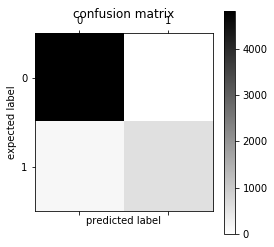

In [38]:
"""
Great! We fit the training data!
Let's see how well we fit the training data.
"""
all_predictions = spam_detector.predict(messages_tfidf)
print(all_predictions)
print('accuracy', accuracy_score(messages['label'], all_predictions))
print('confusion matrix\n', confusion_matrix(messages['label'], all_predictions))
print('(row=expected, col=predicted)')

plt.matshow(confusion_matrix(messages['label'], all_predictions), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

print(classification_report(messages['label'], all_predictions))

Note - Naive Bayes doesn't perfectly match the training data.

* Why is this?
* Would nearest neighbors perfectly match?
* Would linear regression perfectly match?

In [40]:
# TODO pull an example of when the training data is incorrectly fitted

## Step 5: Testing a Model

In [42]:
msg_train, msg_test, label_train, label_test = \
    train_test_split(messages['message'], messages['label'], test_size=0.2)

print('Training set size: ', len(msg_train))
print('Testing set size: ', len(msg_test))
print('Total data set size: ', len(msg_train) + len(msg_test))

Training set size:  4459
Testing set size:  1115
Total data set size:  5574


In [44]:
# Setup the pipeline for processing the data, transforming, and training
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [45]:
# Cross Validation in action!
scores = cross_val_score(pipeline,  # steps to convert raw messages into models
                         msg_train,  # training data
                         label_train,  # training labels
                         cv=10,  # split data randomly into 10 parts: 9 for training, 1 for scoring
                         scoring='accuracy',  # which scoring metric?
                         n_jobs=-1,  # -1 = use all cores = faster
                         )
print('Raw Scores: ', scores)
print('Mean: ', scores.mean(), 'STD: ', scores.std())

Raw Scores:  [ 0.95067265  0.96636771  0.9529148   0.95067265  0.9529148   0.9573991
  0.94618834  0.95067265  0.93946188  0.9505618 ]
Mean:  0.951782637174 STD:  0.00659633626468


For additional exploration of bias, variance, and additional trainers checkout: https://radimrehurek.com/data_science_python/

In [56]:
# TODO Create your own modification

def custom_split_into_lemmas(message):
    message = message.lower() #uncomment this line for first level improvement
    words = TextBlob(message).words
    return [word.lemma for word in words]

messages.message.head(n=5).apply(custom_split_into_lemmas)

# Modify the pipeline to use the custom_split_into_lemmas
custom_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=custom_split_into_lemmas)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
    ])
custom_scores = cross_val_score(
    custom_pipeline,  # steps to convert raw messages into models
    msg_train,  # training data
    label_train,  # training labels
    cv=10,  # split data randomly into 10 parts: 9 for training, 1 for scoring
    scoring='accuracy',  # which scoring metric?
    n_jobs=-1,  # -1 = use all cores = faster
    )
print('Raw Scores: ', custom_scores)
print('Mean: ', custom_scores.mean(), 'STD: ', custom_scores.std())

Raw Scores:  [ 0.94843049  0.96860987  0.95515695  0.94394619  0.94394619  0.94618834
  0.94618834  0.94618834  0.95067265  0.94606742]
Mean:  0.949539476999 STD:  0.00711382421803
